## Setup

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

### Imports

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
from imageio import *
import torch
from skimage.transform import resize
from mpl_toolkits.axes_grid1.axes_rgb import make_rgb_axes, RGBAxes
from torchvision.models import *
from torchvision.datasets import MNIST,KMNIST,FashionMNIST
from skimage.util import montage
from scipy import stats
from torchvision import *
from torch.nn.functional import *

In [100]:
!pip install wandb
import wandb as wb

Defaulting to user installation because normal site-packages is not writeable


In [31]:
def plot(x):
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(5, 5)
    plt.show()

def montage_plot(x):
    x = np.pad(x, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)
    plot(montage(x))

def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))
    
def one_hot(y):
    y2 = GPU_data(torch.zeros((y.shape[0],10)))
    for i in range(y.shape[0]):
        y2[i,int(y[i])] = 1
    return y2



def softmax(x):
    s1 = torch.exp(x - torch.max(x,1)[0][:,None])
    s = s1 / s1.sum(1)[:,None]
    return s



def cross_entropy(outputs, labels):            
    return -torch.sum(softmax(outputs).log()[range(outputs.size()[0]), labels.long()])/outputs.size()[0]  



def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0 
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)


def acc(out,y):
    with torch.no_grad():
        return (torch.sum(torch.max(out,1)[1] == y).item())/y.shape[0]




def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))


def CPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cpu'))

def CPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cpu'))





def plot(x):
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(10, 10)
    plt.show()
    
    
def montage_plot(x):
    x = np.pad(x, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)
    plot(montage(x))    


def get_batch(mode):
    b = c.b
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:,:,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:,:,:]
        y = Y_test[r:r+b]
    return x,y



def vizvec(x): 

    fig, ax = plt.subplots()

    min_val, max_val = 0, 15

    ax.matshow(x, cmap=plt.cm.Blues)
    
    plt.axis('off')

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            c = x[i,j]
            ax.text(j, i, str(c), va='center', ha='center')


def gradient_step(w):

    for j in range(len(w)): 

            w[j].data = w[j].data - c.h*w[j].grad.data
            
            w[j].grad.data.zero_()


def make_plots():
    
    acc_train = acc(model(x,w),y)
    
    xt,yt = get_batch('test')

    acc_test = acc(model(xt,w),yt)

    wb.log({"acc_train": acc_train, "acc_test": acc_test})
    
    

In [32]:
b = 1000

def get_batch(mode):
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y


## MNIST
    

### Load Data

In [9]:
# #MNIST
train_set = MNIST('./data', train=True, download=True)
test_set  = MNIST('./data', train=False, download=True)

#KMNIST
# train_set = KMNIST('./data', train=True, download=True)
# test_set =  KMNIST('./data', train=False, download=True)

# Fashion MNIST
# train_set = FashionMNIST('./data', train=True, download=True)
# test_set =  FashionMNIST('./data', train=False, download=True)

In [10]:
X = train_set.data.numpy()
X_test = test_set.data.numpy()
Y = train_set.targets.numpy()
Y_test = test_set.targets.numpy()

X = X[:,None,:,:]/255
X_test = X_test[:,None,:,:]/255

In [11]:
X.shape

(60000, 1, 28, 28)

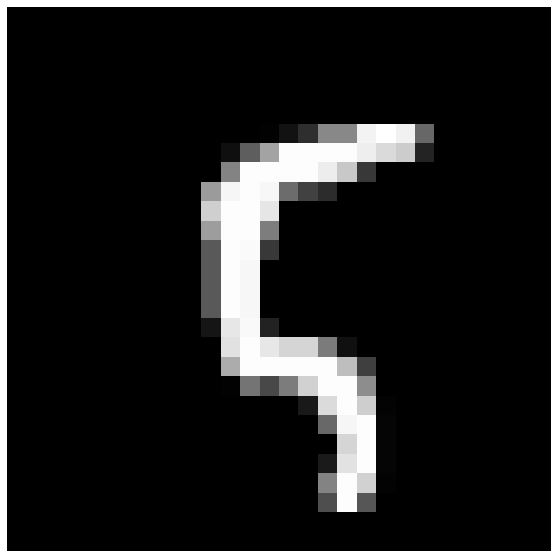

In [12]:
plot(X[100,0,:,:])

In [13]:
Y[100]

5

In [14]:
X[0:25,0,:,:].shape

(25, 28, 28)

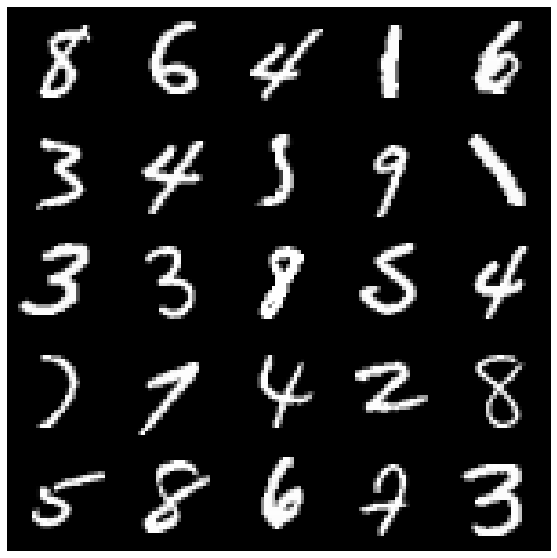

In [15]:
montage_plot(X[125:150,0,:,:])


### Autoencoder


In [43]:
X = CPU_data(X)
Y = CPU_data(Y)
X_test = CPU_data(X_test)
Y_test = CPU_data(Y_test)

In [103]:
X = transforms.functional.normalize(X,0.5,0.5)
X_test = transforms.functional.normalize(X_test,0.5,0.5)

In [104]:
def Encoder(x,w):
    x = relu(conv2d(x,w[0], stride=(2, 2), padding=(1, 1)))
    x = relu(conv2d(x,w[1], stride=(2, 2), padding=(1, 1)))
    x = x.view(x.size(0), 6272)
    x = linear(x,w[2])
    return x

In [105]:
def Decoder(x,w):
    x = linear(x,w[3])
    x = x.view(x.size(0), 128, 7, 7)
    x = relu(conv_transpose2d(x,w[4], stride=(2, 2), padding=(1, 1)))
    x = torch.tanh(conv_transpose2d(x,w[5], stride=(2, 2), padding=(1, 1)))
    return x

In [106]:
def Autoencoder(x,w):
    return Decoder(Encoder(x,w),w)

In [107]:
num_steps = 1000
batch_size = 512
learning_rate = 1e-3

In [ ]:
#Encode
w0 = CPU(randn_trunc((64,1,4,4)))
w1 = CPU(randn_trunc((128,64,4,4)))
w2 = CPU(randn_trunc((10,6272)))
#Decode
w3 = CPU(randn_trunc((6272,10)))
w4 = CPU(randn_trunc((128,64,4,4)))
w5 = CPU(randn_trunc((64,1,4,4)))

w = [w0,w1,w2,w3,w4,w5]

optimizer = torch.optim.Adam(params=w, lr=learning_rate)

for i in range(num_steps):

    x_real,y = get_batch('train')
    
    x_fake = Autoencoder(x_real,w)
    
    loss = torch.mean((x_fake - x_real)**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

    if i % 100 == 0: print(loss.item())

1.6160975694656372
0.16821084916591644


In [109]:
image_batch,y = get_batch('test')

In [ ]:
image_batch_recon = Autoencoder(image_batch,w)

In [ ]:
torch.mean((image_batch_recon - image_batch)**2)

In [ ]:
montage_plot(image_batch[0:25,0,:,:].cpu().detach().numpy())

In [ ]:
montage_plot(image_batch_recon[0:25,0,:,:].cpu().detach().numpy())


### Generator



Convolutional Transpose

In [ ]:
latent_size = 64
hidden_size = 256
image_size = 784
b = 32

In [ ]:
#MNIST
# train_set = datasets.MNIST('./data', train=True, download=True)
# test_set = datasets.MNIST('./data', train=False, download=True)

#KMNIST
#train_set = datasets.KMNIST('./data', train=True, download=True)
#test_set = datasets.KMNIST('./data', train=False, download=True)

#Fashion MNIST
train_set = datasets.FashionMNIST('./data', train=True, download=True)
test_set = datasets.FashionMNIST('./data', train=False, download=True)

In [ ]:
X = train_set.data.numpy()
X_test = test_set.data.numpy()
Y = train_set.targets.numpy()
Y_test = test_set.targets.numpy()
X = X[:,None,:,:]/255
X_test = X_test[:,None,:,:]/255
X = (X - 0.5)/0.5
X_test = (X_test - 0.5)/0.5

In [ ]:
n = 7

index = np.where(Y == n)
X = X[index]
index = np.where(Y_test == n)
X_test = X_test[index]

In [ ]:
X.shape,Y.shape,X_test.shape,Y_test.shape

In [ ]:
###################################################

In [ ]:
X = GPU_data(X)
X_test = GPU_data(X_test)
Y = GPU_data(Y)
Y_test = GPU_data(Y_test)

In [ ]:
x,y = get_batch('train')

In [ ]:
montage_plot(x[0:25,0,:,:].detach().cpu().numpy())

In [ ]:
#D
w0 = GPU(randn_trunc((64,1,4,4)))
w1 = GPU(randn_trunc((128,64,4,4)))
w2 = GPU(randn_trunc((1,6272)))
#G
w3 = GPU(randn_trunc((6272,64)))
w4 = GPU(randn_trunc((128,64,4,4)))
w5 = GPU(randn_trunc((64,1,4,4)))

w = [w0,w1,w2,w3,w4,w5]

In [ ]:
def D(x,w):
    x = relu(conv2d(x,w[0], stride=(2, 2), padding=(1, 1)))
    x = relu(conv2d(x,w[1], stride=(2, 2), padding=(1, 1)))
    x = x.view(x.size(0), 6272)
    x = linear(x,w[2])
    x = torch.sigmoid(x)
    return x

In [ ]:
def G(x,w):
    x = linear(x,w[3])
    x = x.view(x.size(0), 128, 7, 7)
    x = relu(conv_transpose2d(x,w[4], stride=(2, 2), padding=(1, 1)))
    x = torch.tanh(conv_transpose2d(x,w[5], stride=(2, 2), padding=(1, 1)))
    return x

In [ ]:
d_optimizer = torch.optim.Adam(w[0:3], lr=0.0002)
g_optimizer = torch.optim.Adam(w[3:], lr=0.0002)

real_labels = Variable(torch.ones(batch_size, 1).cuda())
fake_labels = Variable(torch.zeros(batch_size, 1).cuda())

In [ ]:
num_epochs = 500 
batches = X.shape[0]//batch_size
steps = num_epochs*batches

In [ ]:
z1 = Variable(torch.randn(steps,batch_size,latent_size).cuda())
z2 = Variable(torch.randn(steps,batch_size,latent_size).cuda())

In [ ]:
for i in range(steps):
        
    images,y = get_batch('train')
        
    d_loss = binary_cross_entropy(D(images,w), real_labels) + binary_cross_entropy(D(G(z1[i],w),w), fake_labels)
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
       
    
    g_loss = binary_cross_entropy(D(G(z2[i],w),w), real_labels)
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    
    if i % 2000 == 0:
        out = G(z1[np.random.randint(steps)],w)
        montage_plot(out.view(batch_size,1,28,28).detach().cpu().numpy()[0:25,0,:,:])